In [138]:
import numpy as np
import pandas as pd
import torch
device = torch.device("mps")

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
pop = pd.read_csv('data/songs_liwc_25_03_13.csv').iloc[:, 2:]
pop.columns

Index(['artist', 'album', 'song', 'lyrics', 'Segment', 'WC', 'Analytic',
       'Clout', 'Authentic', 'Tone',
       ...
       'nonflu', 'filler', 'AllPunc', 'Period', 'Comma', 'QMark', 'Exclam',
       'Apostro', 'OtherP', 'Emoji'],
      dtype='object', length=123)

In [142]:
torch.backends.mps.is_available()
torch.backends.mps.is_built()
device

device(type='mps')

In [143]:
# processing: currently leaving punctuation alone
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess

pop['lyrics'] = pop['lyrics'].astype(str).apply(remove_stopwords)
pop['lyrics-tokenized'] = pop['lyrics'].apply(simple_preprocess)


In [ ]:
# emotion detection with distilroberta
# https://huggingface.co/j-hartmann/emotion-english-distilroberta-base
from transformers import pipeline
emotion_model = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True,
    device=0  # Use GPU/MPS if available, change to -1 for CPU if needed
)

# Process the entire column in batch (more efficient than applying row by row)
predictions = emotion_model(pop['lyrics'].tolist(), batch_size=8)

print(predictions[:3])


[{'label': 'surprise', 'score': 0.3331131935119629}, {'label': 'joy', 'score': 0.8332006335258484}, {'label': 'anger', 'score': 0.7291033267974854}]


In [154]:
# Extract only the emotion label from each prediction
pop['emotion'] = [pred['label'] for pred in predictions]  # Extract emotion labels
pop['emotion_score'] = [pred['score'] for pred in predictions]  # Extract confidence scores


In [314]:
# add NRC
#https://www.geeksforgeeks.org/emotion-classification-using-nrc-lexicon-in-python/
from nrclex import NRCLex

#google ai popup:
def analyze_emotion(text):
    if isinstance(text, str):
        emotion_lexicon = NRCLex(text)
        return emotion_lexicon.raw_emotion_scores
    else:
        return {} 

#pop = pop.join(pop['emotion_scores'].apply(pd.Series))
pop['emotion_scores'] = pop['lyrics'].apply(analyze_emotion)

In [315]:
pop = pop.join(pop['emotion_scores'].apply(pd.Series).add_prefix("nrc_"))

ValueError: columns overlap but no suffix specified: Index(['nrc_trust', 'nrc_anticipation', 'nrc_fear', 'nrc_surprise',
       'nrc_positive', 'nrc_negative', 'nrc_joy', 'nrc_sadness', 'nrc_anger',
       'nrc_disgust'],
      dtype='object')

In [316]:
pop.columns

Index(['artist', 'album', 'song', 'lyrics', 'Segment', 'WC', 'Analytic',
       'Clout', 'Authentic', 'Tone',
       ...
       'nrc_trust', 'nrc_anticipation', 'nrc_fear', 'nrc_surprise',
       'nrc_positive', 'nrc_negative', 'nrc_joy', 'nrc_sadness', 'nrc_anger',
       'nrc_disgust'],
      dtype='object', length=146)

In [317]:
# work on PCA -- have distilbert, NRC + LIWC

pop.to_csv('data/songs_expanded_25_04_01.csv', index=False)

In [318]:
# now LIWC, NRC, distilbert all together : time for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pop_scale =  pop.select_dtypes(include='number').fillna(0)
scl = pd.DataFrame(scaler.fit_transform(pop_scale)) 

In [319]:
scl.columns = pop_scale.columns
scl.head()


,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,Dic,Linguistic,...,nrc_trust,nrc_anticipation,nrc_fear,nrc_surprise,nrc_positive,nrc_negative,nrc_joy,nrc_sadness,nrc_anger,nrc_disgust
0,0.0,-0.765406,1.631144,-0.330791,0.918852,-1.228857,-0.175148,1.180456,-0.473812,0.051885,...,-0.669545,-0.736665,-0.700296,-0.409656,-1.041824,-0.966459,-1.026358,-1.012948,-0.871721,-0.783610
1,0.0,-0.217822,-0.968323,1.799534,-0.351041,1.930779,-1.083758,0.292756,0.404468,1.312491,...,-0.377931,-0.414731,-0.961041,-0.851930,-0.461932,-0.617525,-0.253595,-0.710191,-0.637167,-0.488326
2,0.0,0.097039,1.334962,-1.002378,0.918852,-1.041347,0.823150,-0.944868,0.278999,0.441365,...,-0.086318,-0.414731,0.342684,-0.851930,-0.461932,-0.094125,-0.768771,0.500835,0.066496,-0.193042
3,0.0,-0.573752,-0.040312,-0.595883,-0.127126,-1.228857,0.046696,-0.217396,0.716746,1.018151,...,-0.961158,-0.736665,-0.439551,-0.851930,-1.235121,-0.268592,-0.511183,-0.407435,-0.637167,-0.783610
4,0.0,-0.464235,-0.764623,1.733624,0.735207,-0.819037,-0.840681,-0.016650,0.450938,0.966617,...,-0.669545,-0.736665,-0.439551,-0.409656,-0.461932,-0.094125,-0.768771,0.198078,-0.402612,-0.193042


In [320]:
#https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/Principal%20Component%20Analysis.ipynb 
#from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pop_pca = pca.fit(scl)

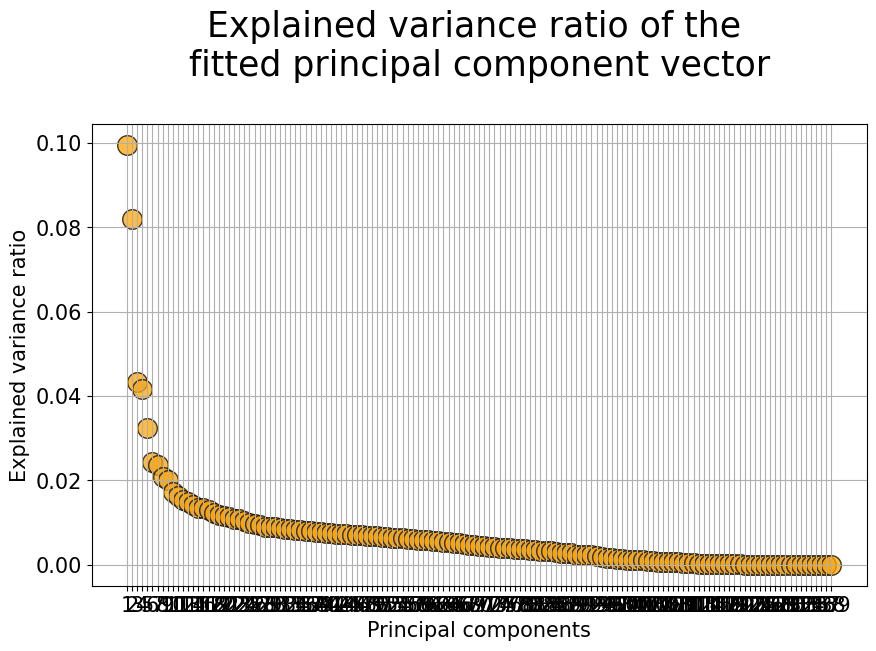

In [321]:
# explained variance ratio 
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(pop_pca.explained_variance_ratio_))],
            y=pop_pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(pop_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [322]:
pop_pca_trans = pd.DataFrame(pca.transform(scl))


[pca] >Extracting column labels from dataframe.
[pca] >The PCA reduction is performed on the [139] columns of the input dataframe.
[pca] >Fit using PCA.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled on

[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


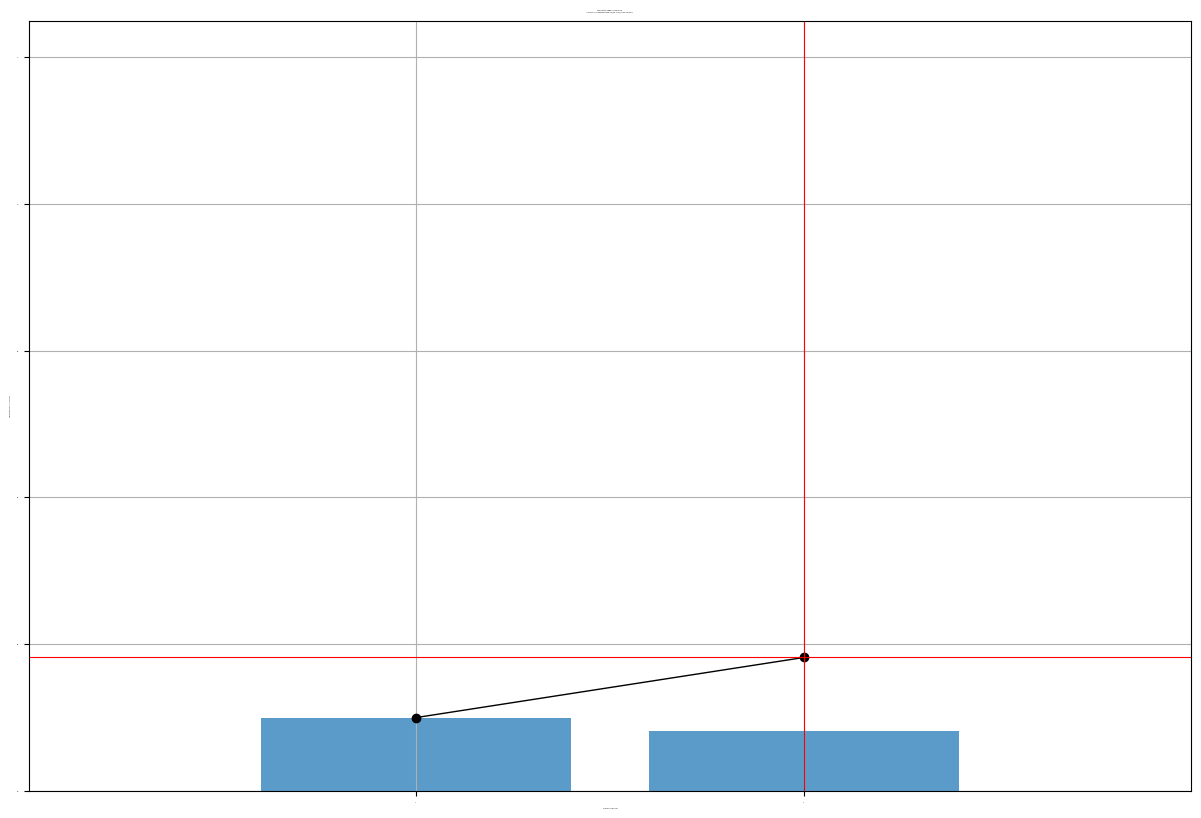

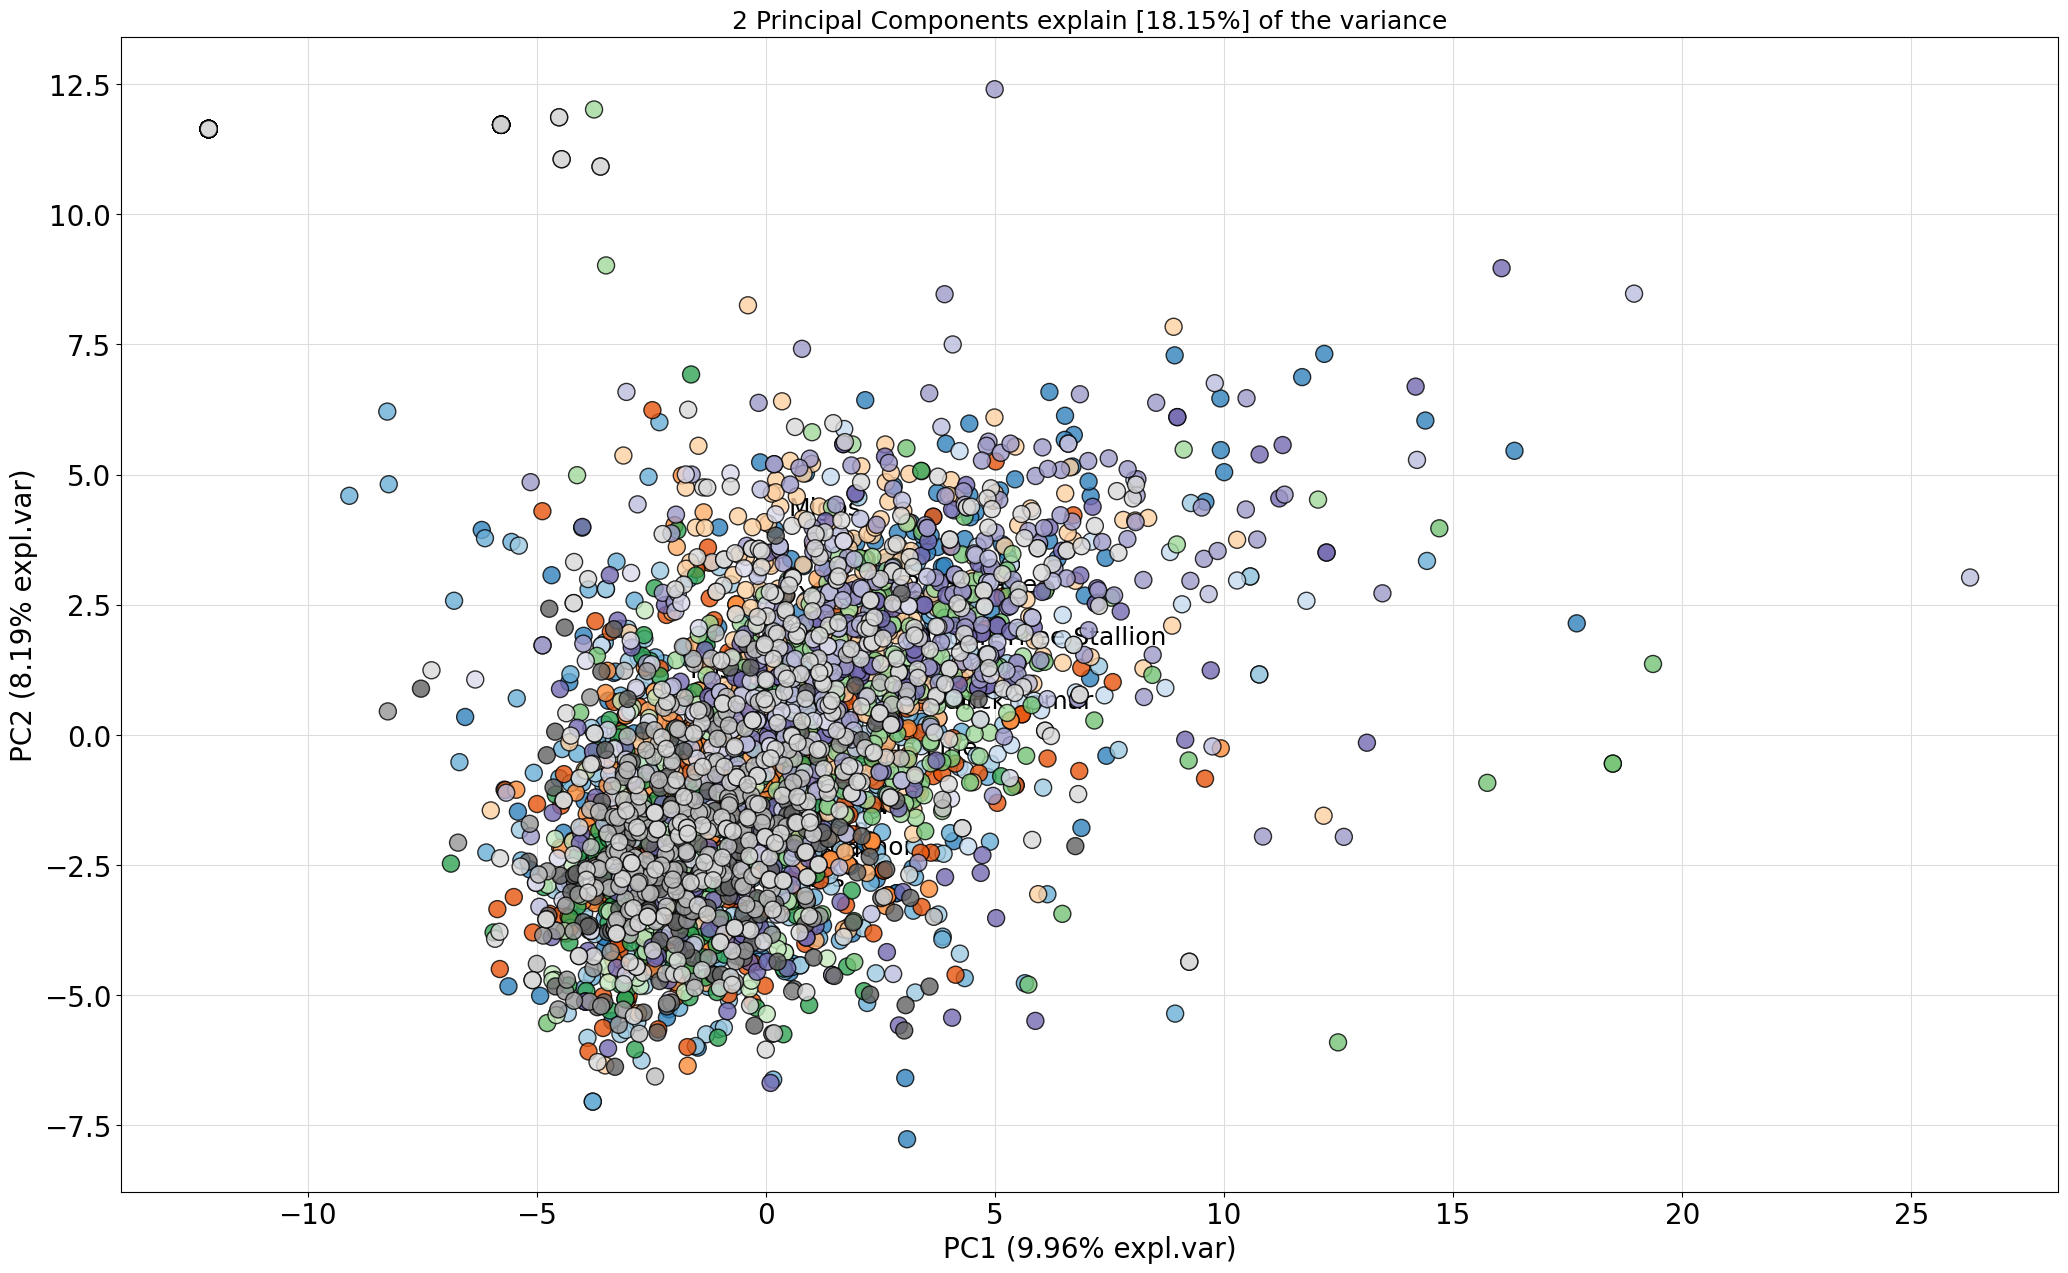

In [323]:
#https://erdogant.github.io/pca/pages/html/index.html
from pca import pca
#model = pca(n_components=0.95)
# ... or explicitly specify the number of PCs
model = pca(n_components=2)

# Fit and transform
results = model.fit_transform(X=scl, row_labels = pop["artist"])

# Plot the explained variance
fig, ax = model.plot()

# Scatter the first two PCs
fig, ax = model.scatter()



[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd]

[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.
120 [-0.24805539  0.30667534]
129 [-0.8345502   0.45822146]


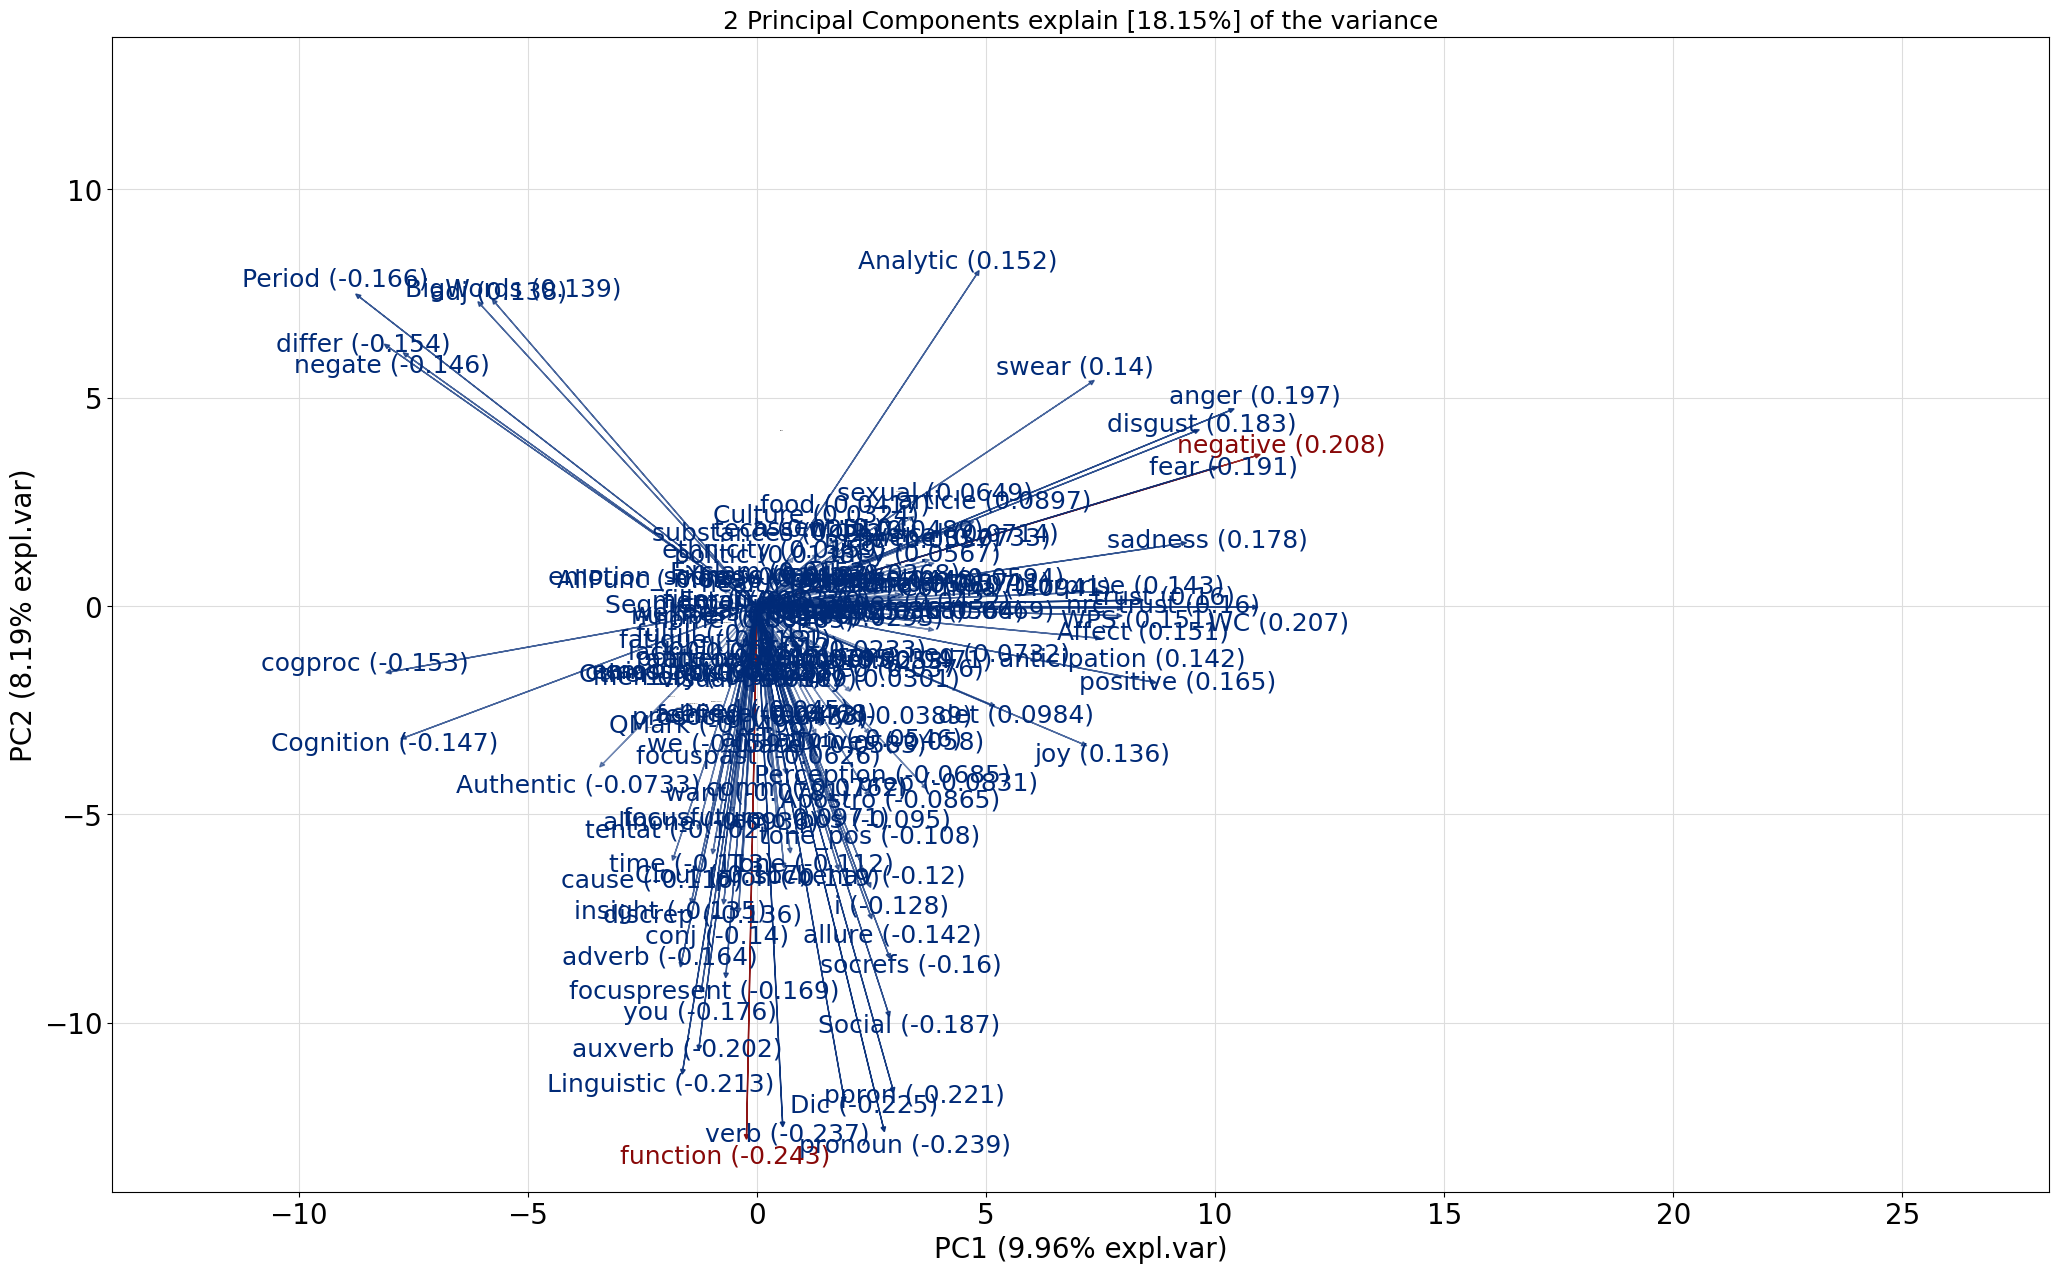

In [324]:
# Create a biplot
fig, ax = model.biplot(n_feat=130, cmap=None)


In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(pop_pca_trans[0],pop_pca_trans[1],c=pop['artist'], edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
plt.title("Class separation using first two principal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()

In [382]:
# smaller scale version
# Create a list of columns that start with "nrc_"
nrc_columns = [col for col in pop.columns if col.startswith("nrc_")] + ["Linguistic", "Analytic", "Authentic", "Tone","emo_pos", "emo_neg", "artist", "lyrics"]
               

# Filter DataFrame to keep only "nrc_" columns
pop_small = pop[nrc_columns]


# Process the entire column in batch (more efficient than applying row by row)
predictions_sm = emotion_model(pop_small['lyrics'].tolist(), batch_size=8)

print(predictions_sm[:3])

[{'label': 'surprise', 'score': 0.3331131935119629}, {'label': 'joy', 'score': 0.8332006335258484}, {'label': 'anger', 'score': 0.7291033267974854}]


In [384]:
pop_small.columns


Index(['nrc_trust', 'nrc_anticipation', 'nrc_fear', 'nrc_surprise',
       'nrc_positive', 'nrc_negative', 'nrc_joy', 'nrc_sadness', 'nrc_anger',
       'nrc_disgust', 'Linguistic', 'Analytic', 'Authentic', 'Tone', 'emo_pos',
       'emo_neg', 'artist', 'lyrics'],
      dtype='object')

In [385]:
pop_small.loc[:, "row_id"] = pop_small.groupby(["artist", "lyrics"]).ngroup()


/var/folders/g1/9qqnjd1x21dbm_sdrj7lhrlw0000gn/T/ipykernel_37841/526365498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_small.loc[:, "row_id"] = pop_small.groupby(["artist", "lyrics"]).ngroup()


In [386]:
# Extract only the emotion label from each prediction
pop_small['emotion'] = [pred['label'] for pred in predictions_sm]  # Extract emotion labels
pop_small['emotion_score'] = [pred['score'] for pred in predictions_sm]  # Extract confidence scores



/var/folders/g1/9qqnjd1x21dbm_sdrj7lhrlw0000gn/T/ipykernel_37841/3572578106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_small['emotion'] = [pred['label'] for pred in predictions_sm]  # Extract emotion labels
/var/folders/g1/9qqnjd1x21dbm_sdrj7lhrlw0000gn/T/ipykernel_37841/3572578106.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_small['emotion_score'] = [pred['score'] for pred in predictions_sm]  # Extract confidence scores


In [387]:
# pivot wider:
pop_small_exp = pop_small.pivot_table(
    index=["artist", "lyrics"] + [col for col in pop_small.columns if col.startswith("nrc_") or col in ["Linguistic", "Analytic", "Tone", "emo_pos", "emo_neg", "Authentic"]],
    columns="emotion",
    values="emotion_score",
    aggfunc="mean"  # or 'max', 'min', 'first', etc.
).reset_index()



In [388]:
# now LIWC, NRC, distilbert all together : time for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pop_sm_scale =  pop_small_exp.select_dtypes(include='number').fillna(0)
scl2 = pd.DataFrame(scaler.fit_transform(pop_sm_scale)) 



In [393]:
scl2.columns = pop_sm_scale.columns
scl2.head()


emotion,nrc_trust,nrc_anticipation,nrc_fear,nrc_surprise,nrc_positive,nrc_negative,nrc_joy,nrc_sadness,nrc_anger,nrc_disgust,...,Tone,emo_pos,emo_neg,anger,disgust,fear,joy,neutral,sadness,surprise
0,-0.458387,-0.475683,-0.808346,-0.404477,-0.406018,-0.690210,-0.530907,-0.778817,-0.362696,-0.313812,...,2.283672,2.500519,-0.160923,-0.721140,-0.089331,-0.326795,1.731161,-0.390850,-0.421224,-0.275603
1,-0.458387,-0.156509,1.137940,-0.404477,-0.210659,0.986561,-0.530907,0.959299,1.134723,1.311614,...,-0.559449,-0.687778,-0.221803,2.152290,-0.089331,-0.326795,-0.344931,-0.390850,-0.421224,-0.275603
2,-1.012272,0.162665,-0.078488,0.411151,-0.406018,-0.019502,0.267320,-0.489131,-0.148779,-0.313812,...,-0.012626,-0.687778,-0.718987,-0.721140,-0.089331,-0.326795,-0.344931,2.956645,-0.421224,-0.275603
3,-1.012272,-0.475683,2.840940,0.003337,-0.992095,1.657269,-1.063058,3.566473,2.632141,3.478848,...,-1.253536,0.720326,4.181833,2.054549,-0.089331,-0.326795,-0.344931,-0.390850,-0.421224,-0.275603
4,-1.012272,-0.475683,0.894654,0.411151,-0.601377,0.651207,-0.264831,0.959299,0.492972,0.498901,...,-1.158248,-0.687778,-0.718987,1.781567,-0.089331,-0.326795,-0.344931,-0.390850,-0.421224,-0.275603


[pca] >Extracting column labels from dataframe.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [23] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


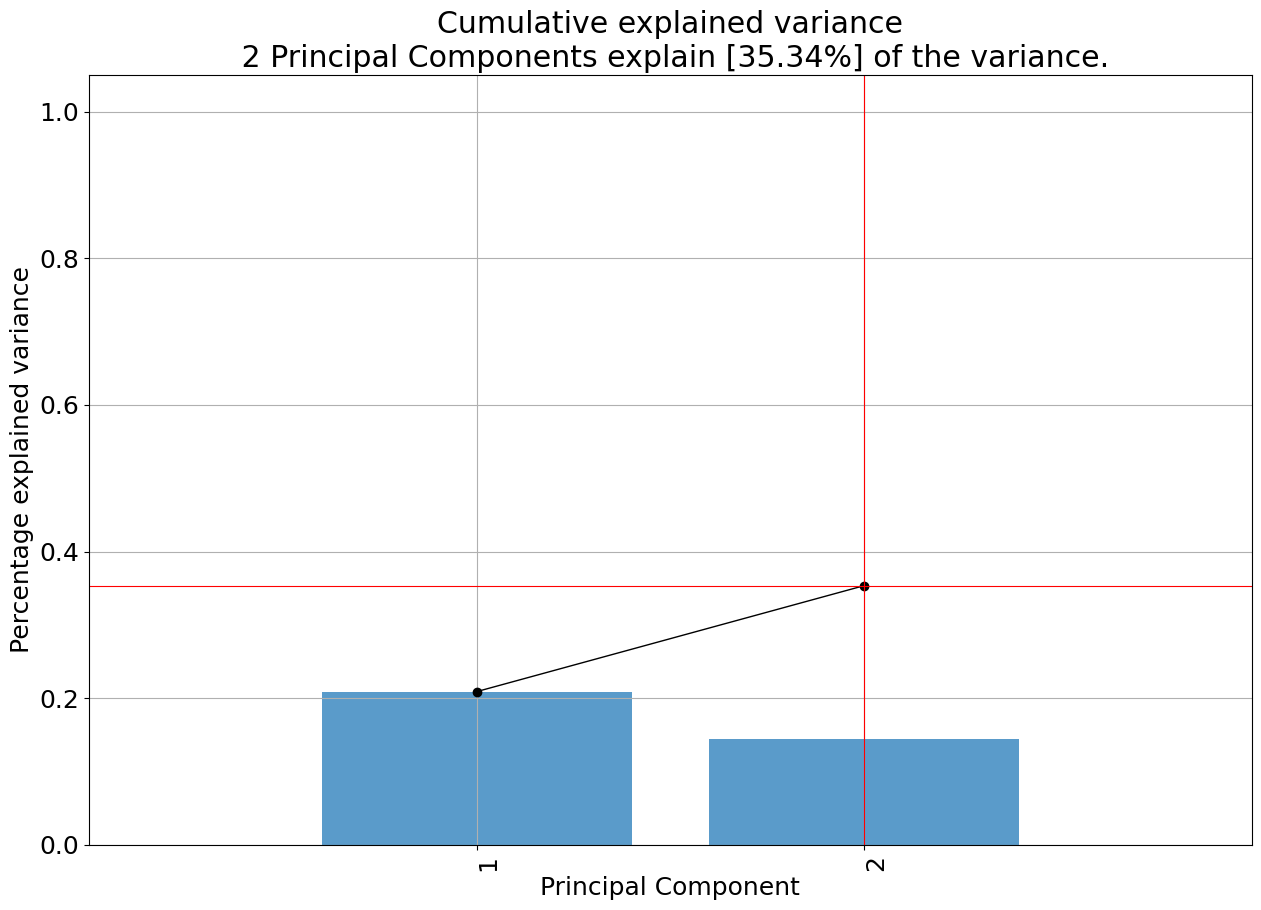

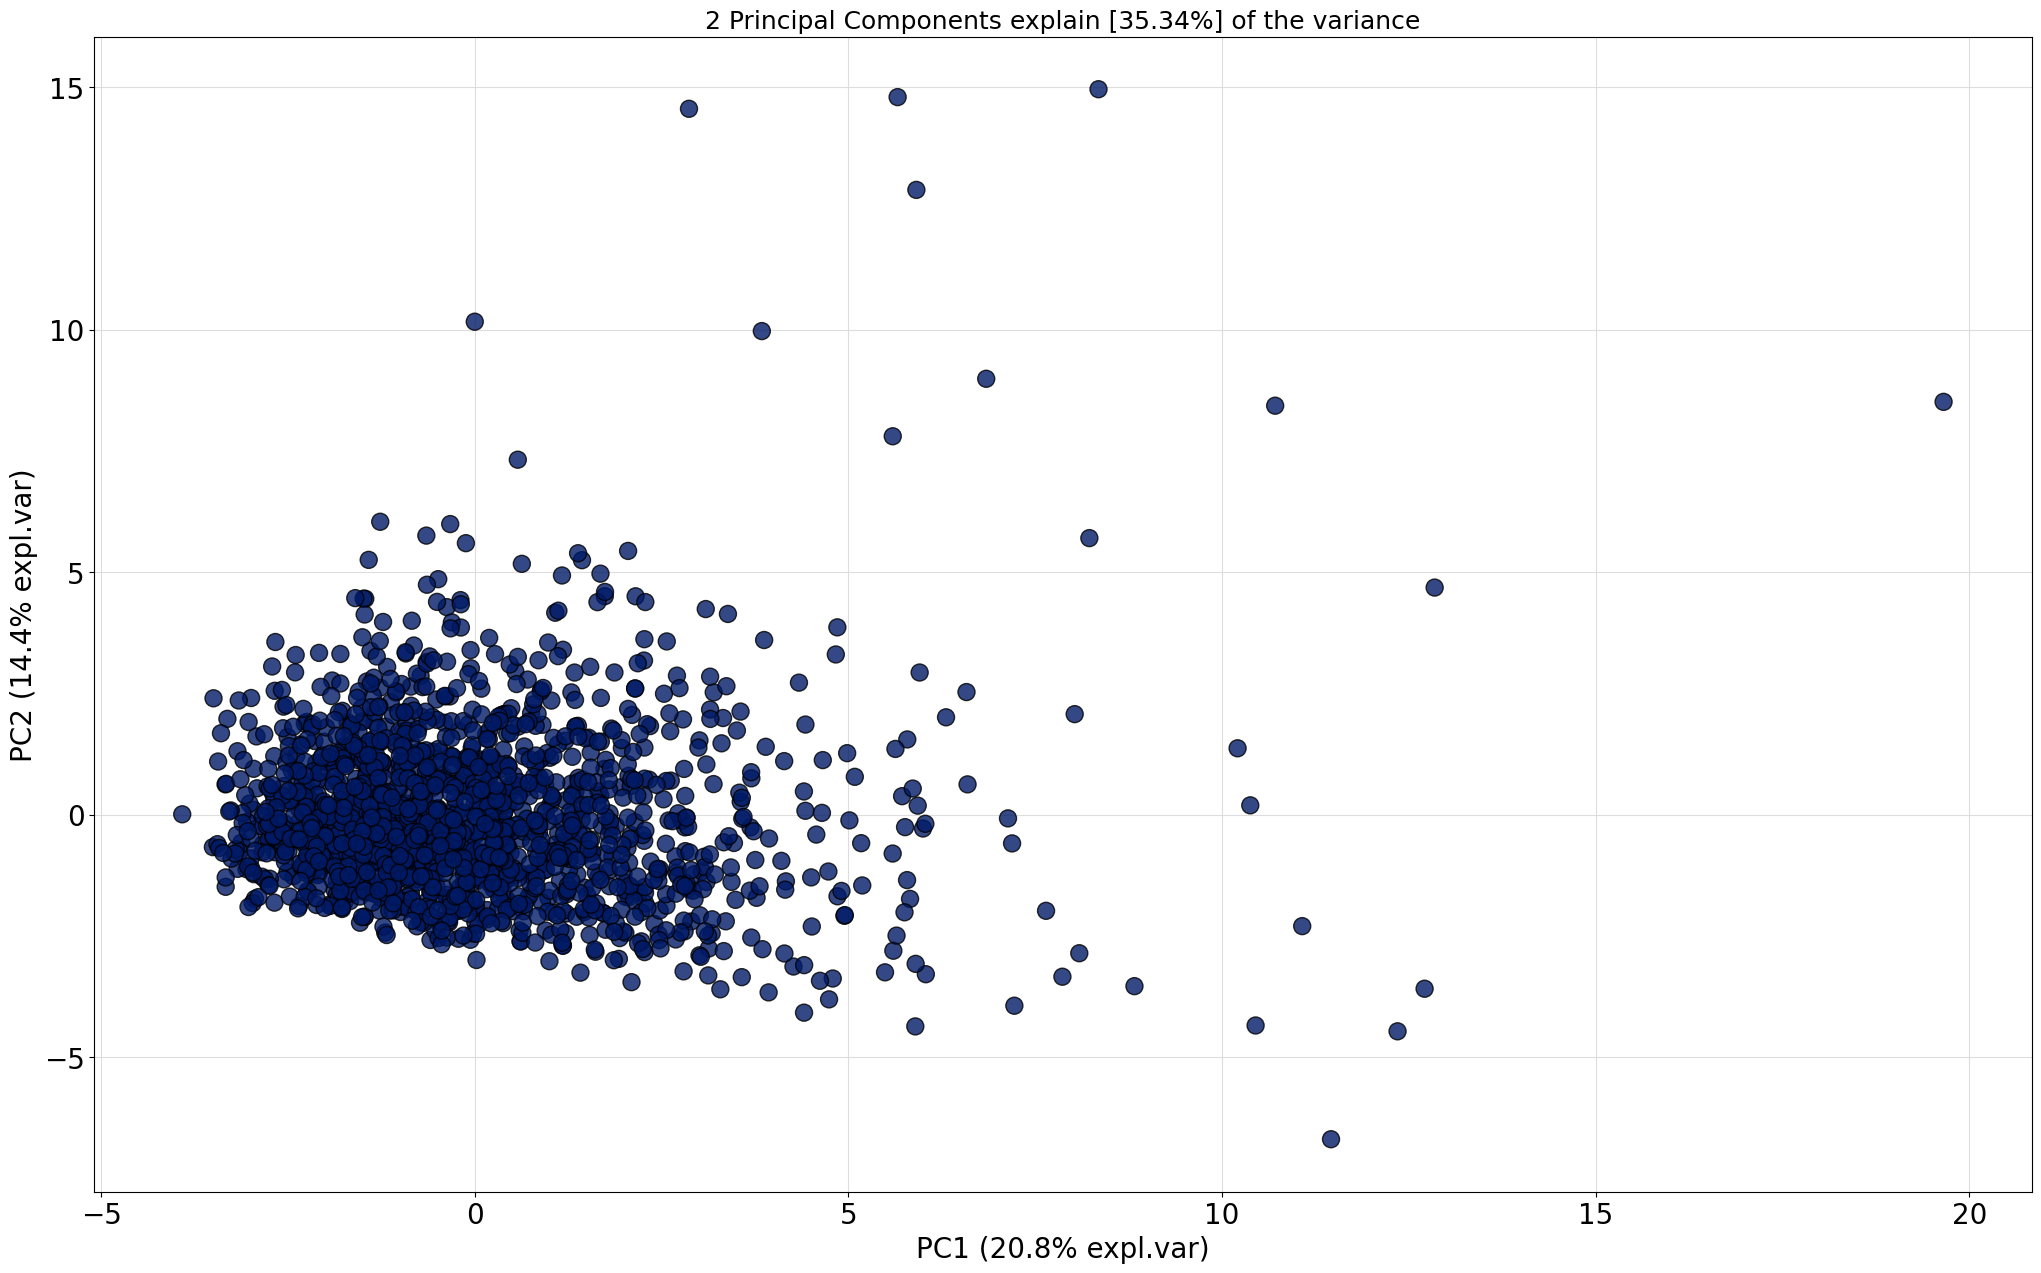

In [395]:
from pca import pca
#model2 = pca(n_components=0.95)
# ... or explicitly specify the number of PCs
model2 = pca(n_components=2)

# Fit and transform
results = model2.fit_transform(X=scl2, row_labels = pop_small["artist"])

# Plot the explained variance
fig, ax = model2.plot()

# Scatter the first two PCs
fig, ax = model2.scatter()


In [396]:
pop_small_exp.shape

(1711, 25)

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


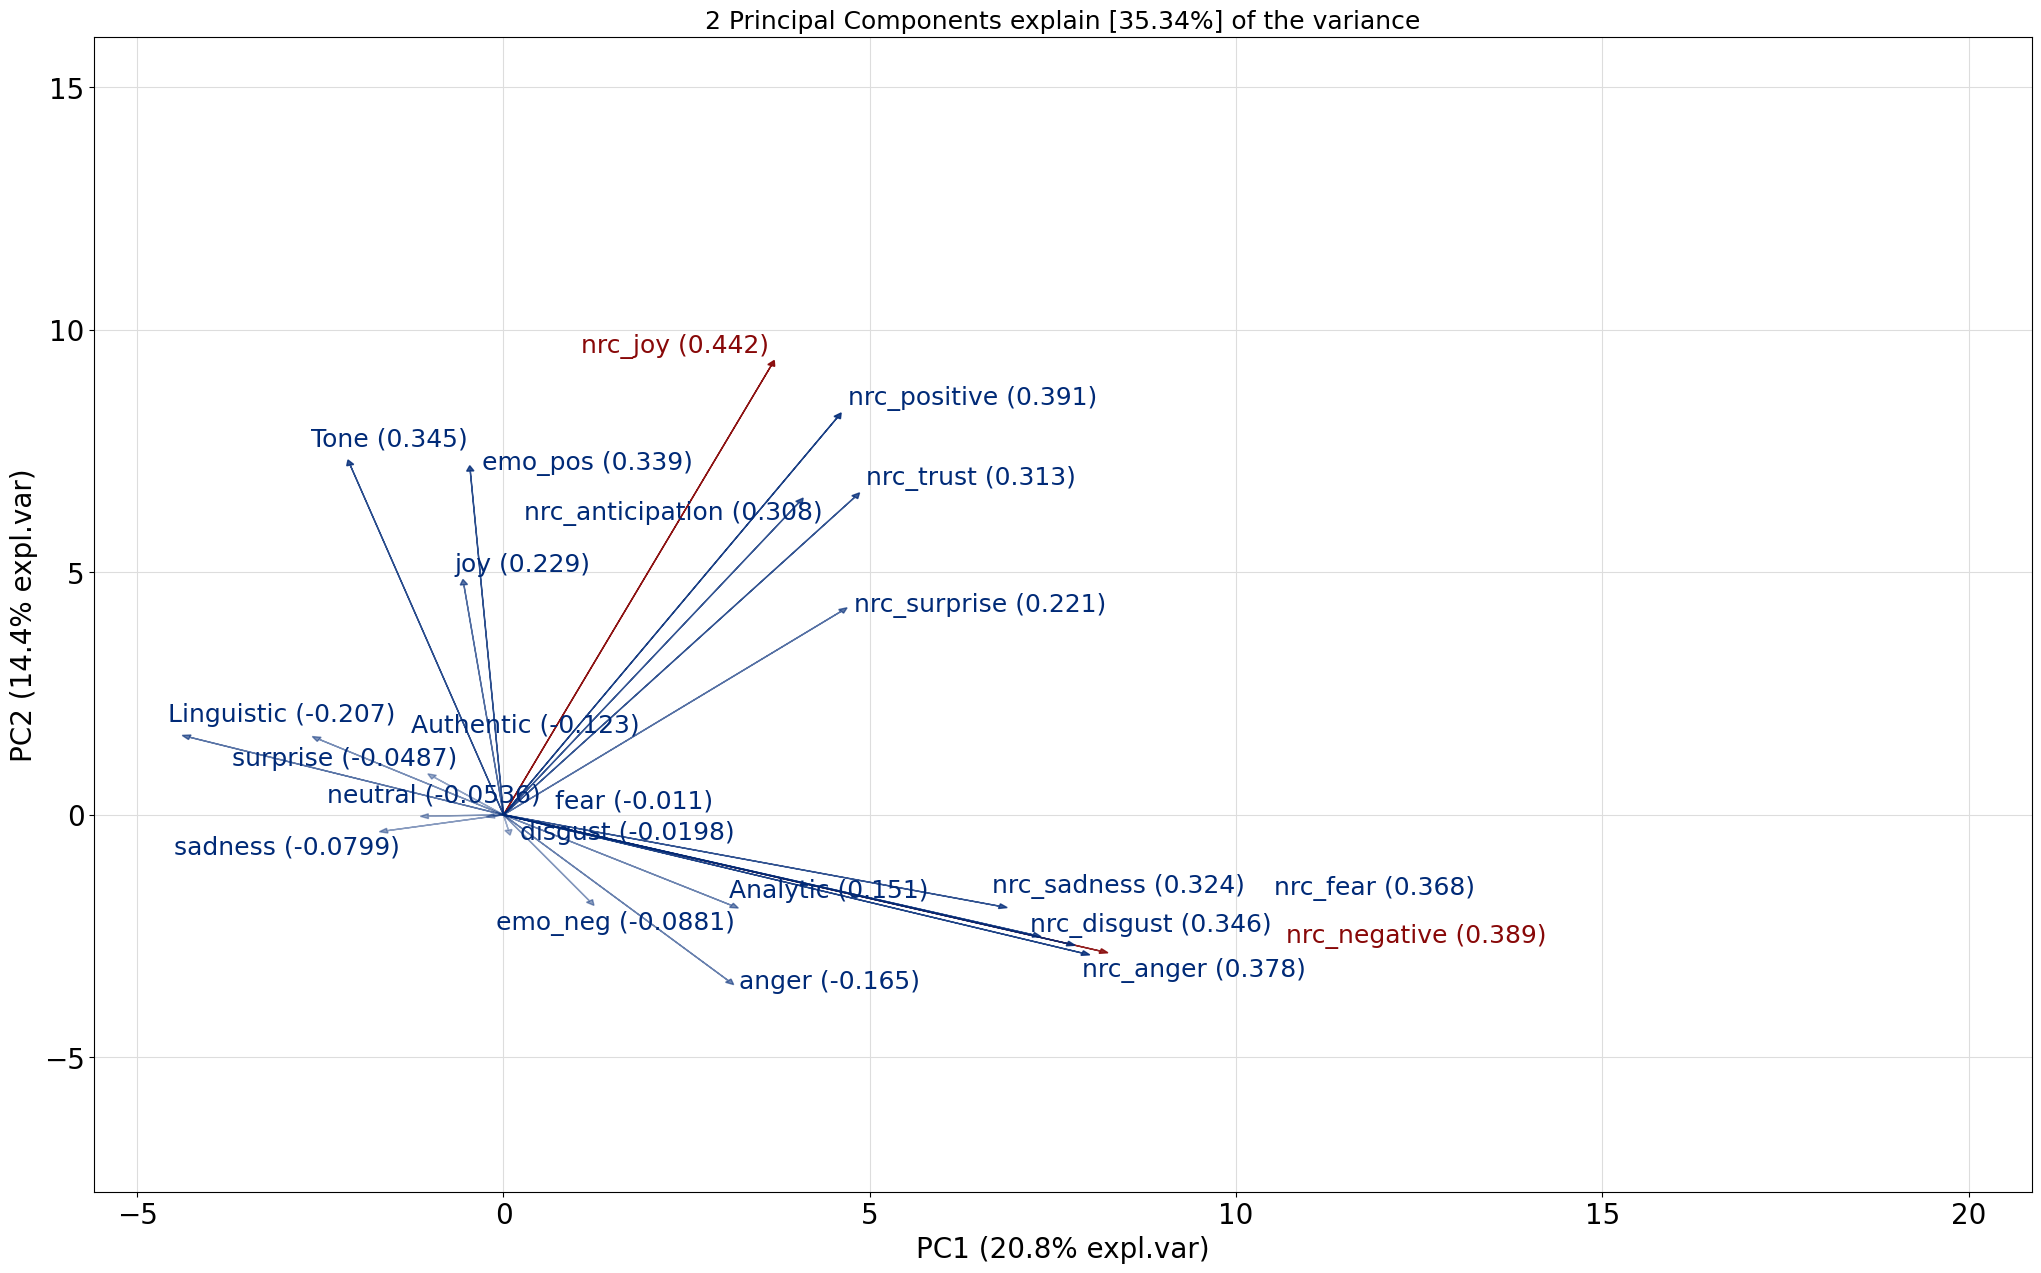

In [397]:
# Create a biplot
fig, ax = model2.biplot(n_feat=25, cmap=None)

In [398]:
pop_small_exp.columns

Index(['artist', 'lyrics', 'nrc_trust', 'nrc_anticipation', 'nrc_fear',
       'nrc_surprise', 'nrc_positive', 'nrc_negative', 'nrc_joy',
       'nrc_sadness', 'nrc_anger', 'nrc_disgust', 'Linguistic', 'Analytic',
       'Authentic', 'Tone', 'emo_pos', 'emo_neg', 'anger', 'disgust', 'fear',
       'joy', 'neutral', 'sadness', 'surprise'],
      dtype='object', name='emotion')

In [404]:
pop_four = pop_small_exp[['Linguistic', 'Analytic', 'joy', 'anger']]

In [405]:
# now LIWC, NRC, distilbert all together : time for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pop_four_scale =  pop_four.select_dtypes(include='number').fillna(0)
scl3 = pd.DataFrame(scaler.fit_transform(pop_four_scale)) 

scl3.columns = pop_four_scale.columns
scl3.head()

emotion,Linguistic,Analytic,joy,anger
0,-0.559338,0.649024,1.731161,-0.721140
1,-0.948149,0.980808,-0.344931,2.152290
2,-3.446851,0.435009,-0.344931,-0.721140
3,-2.404448,1.909155,-0.344931,2.054549
4,-2.171718,1.070151,-0.344931,1.781567


[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


[scatterd] >INFO> Create scatterplot


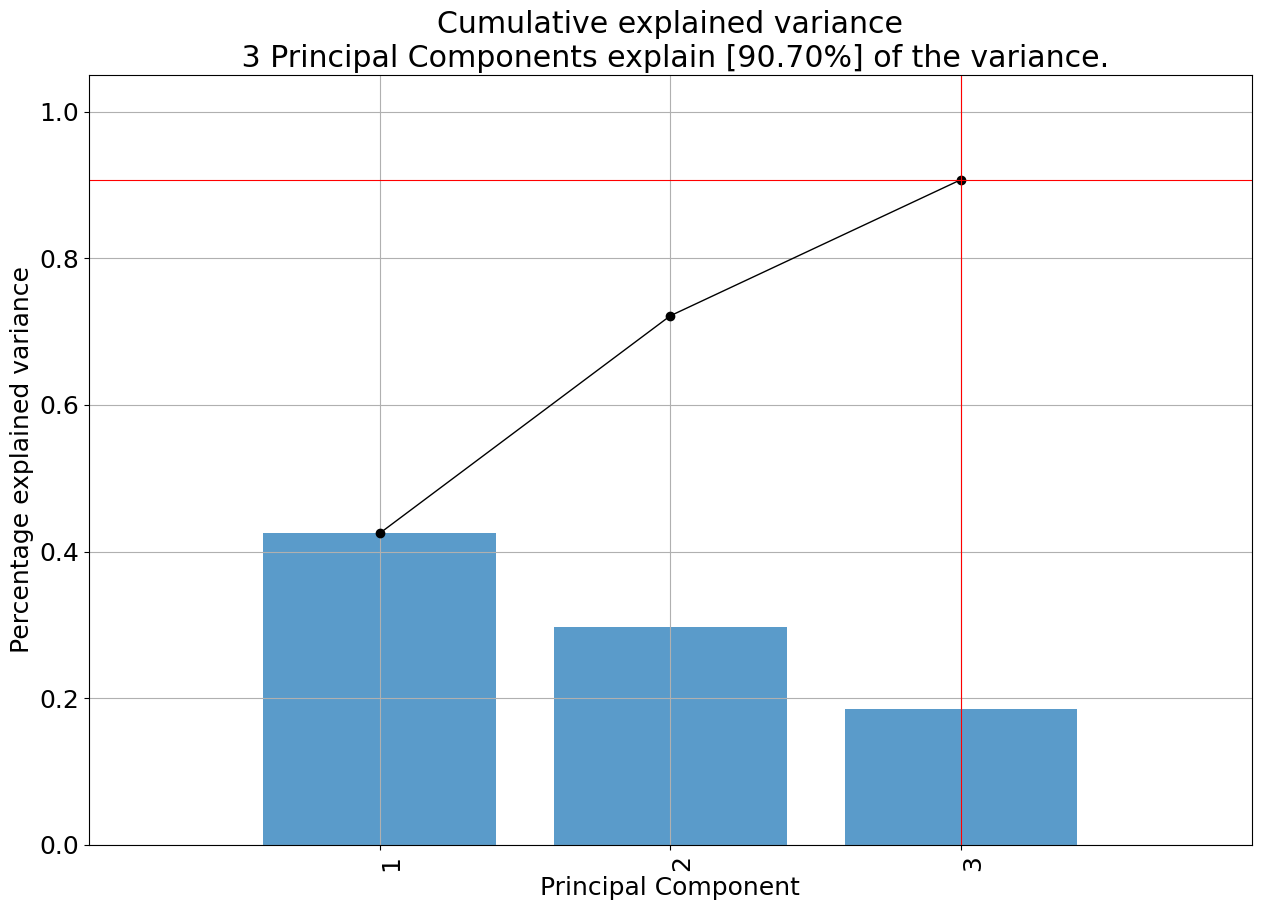

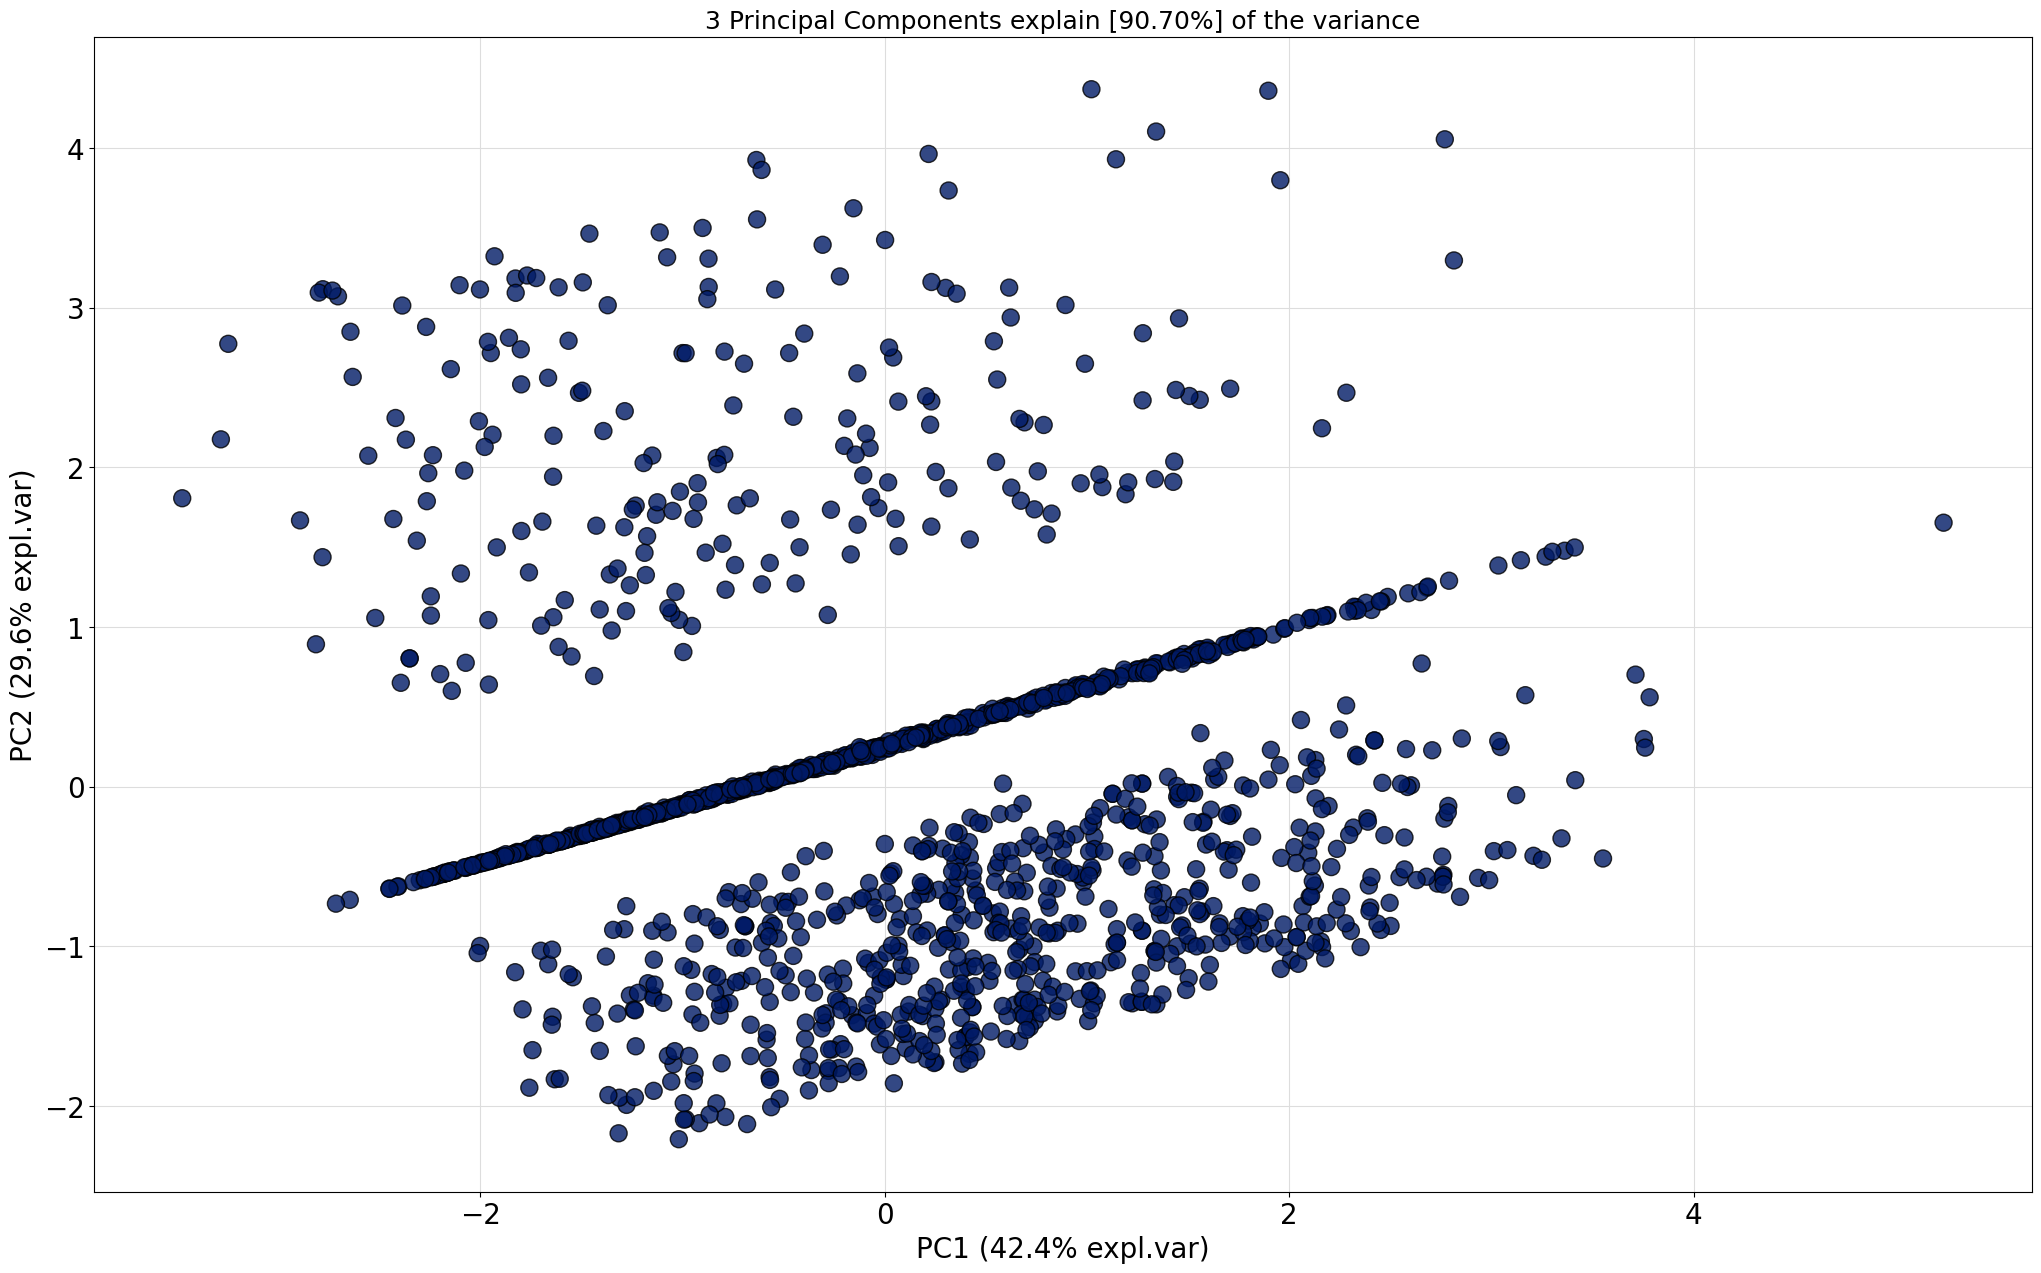

In [407]:
from pca import pca

# ... or explicitly specify the number of PCs
model3 = pca(n_components=3)

# Fit and transform
results = model3.fit_transform(X=scl3)

# Plot the explained variance
fig, ax = model3.plot()

# Scatter the first two PCs
fig, ax = model3.scatter()

In [408]:
# Scatter the first two PCs
#fig, ax = model3.scatter()
# for artist, group in model3.groupby('artist'):
#     ax.scatter(group['x'], group['y'], label=artist)

# ax.legend()
# plt.show()


[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


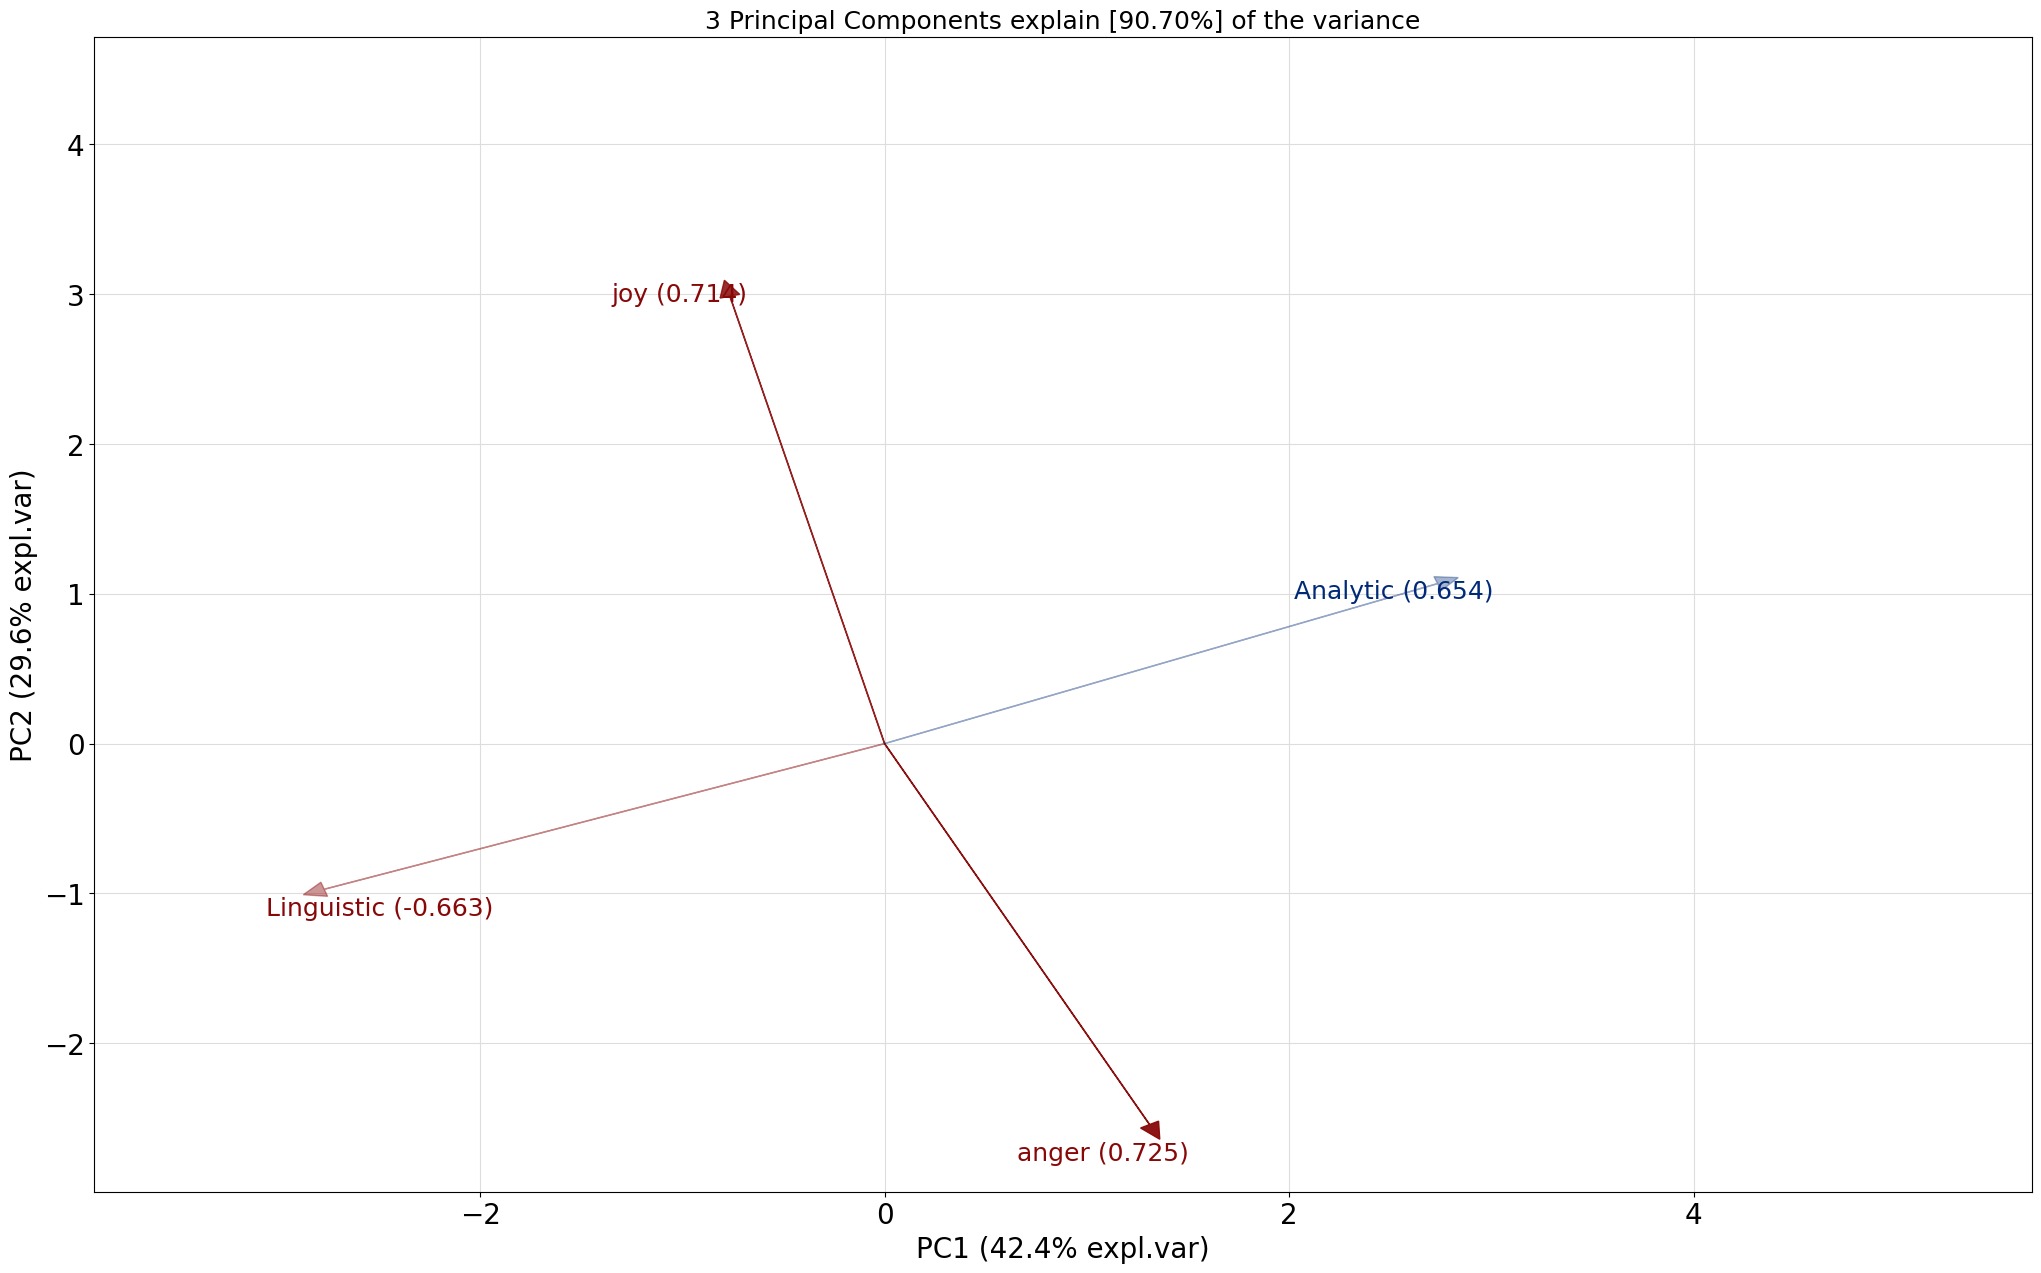

In [409]:
# Create a biplot
fig, ax = model3.biplot(n_feat=17, cmap=None)